# Sandbox for ndoperators.solvers

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Operator imports
import ndoperators as ops
import llops as yp

# Solver-specific imports
from ndoperators.solvers import objectivefunctions, regularizers
import ndoperators.solvers as solvers

ops.setDefaultBackend('arrayfire') # arrayfire or numpy
ops.setDefaultDatatype('float32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Forward Model For Convolutional System with Windowing

/Users/zfphil/.conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


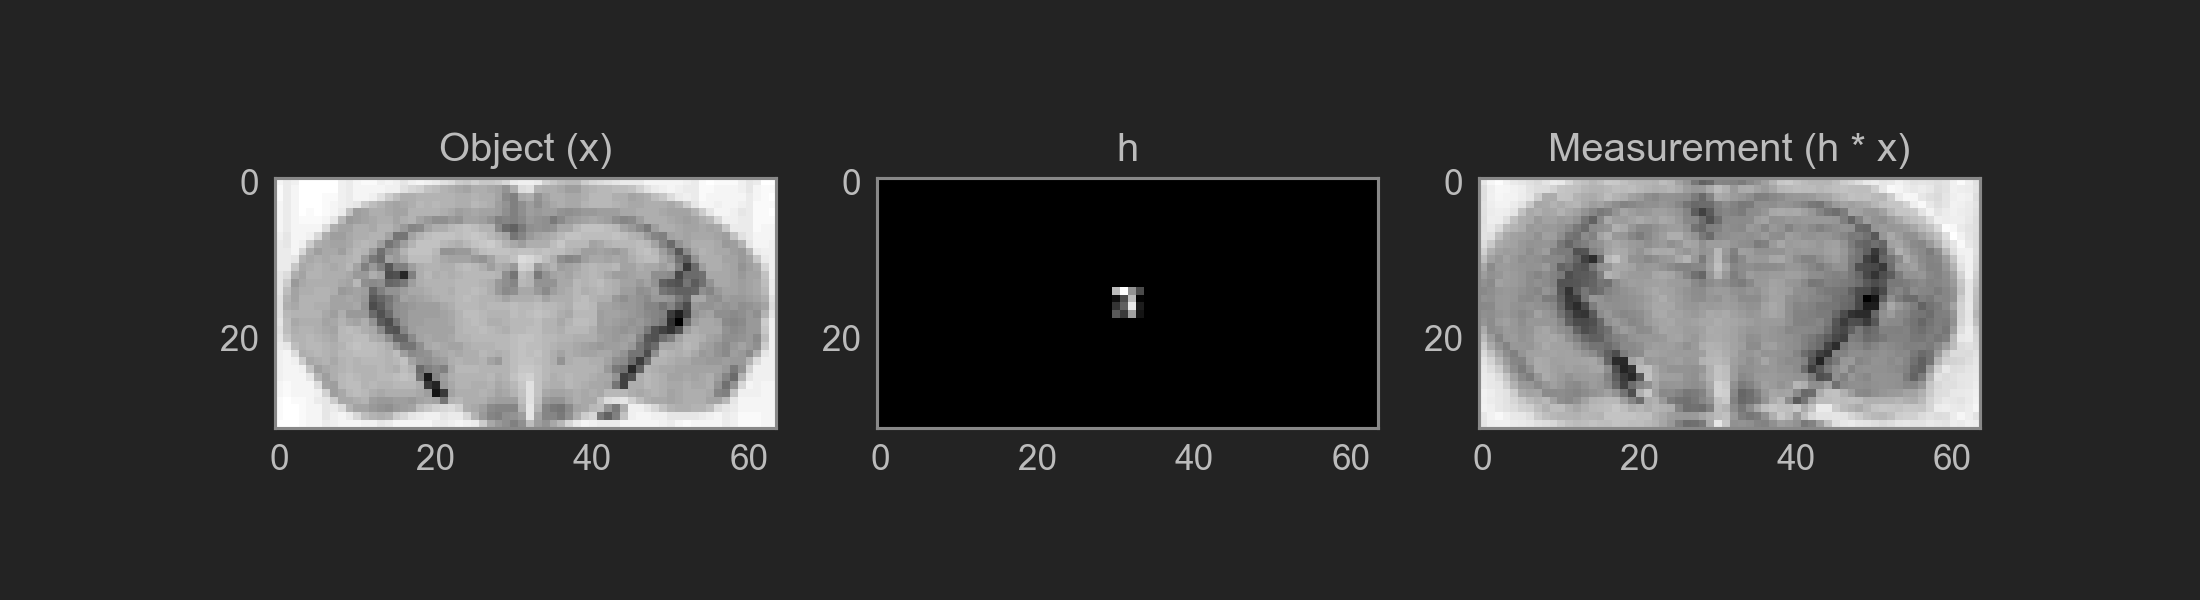

In [2]:
# Image to use when generating object
object_file_name = '../test/brain_to_scan.png'

# Color channel to use when generating object
object_color_channel = 2

# Image size to simulate
image_size = np.array([32, 64])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
brain = imageio.imread(object_file_name)
object_true = np.asfortranarray(sp.misc.imresize(brain, size=image_size)[:, :, object_color_channel].astype(yp.getNativeDatatype(global_dtype, 'numpy')) / 255.)
object_true = yp.asbackend(object_true)

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(h))

A = ops.Convolution(h, mode='circular', pad_value='mean')
y = A * object_true

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(np.asarray(h)), cmap='gray')
plt.title('h')
plt.subplot(133)
plt.imshow((np.abs(y)), cmap='gray')
plt.title('Measurement (h * x)');

## TV Regularization

In [28]:
import arrayfire
arrayfire.device.set_manual_eval_flag(True)

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    7.72e+02    |       0.00       |    0.00e+00    |  169.9 MB /    0.9 MB  |
|   20   |    9.19e-01    |       0.87       |    3.59e-02    |  231.0 MB /    0.5 MB  |
|   40   |    8.89e-01    |       1.42       |    4.82e-03    |  231.0 MB /    0.5 MB  |
|   60   |    8.88e-01    |       1.97       |    6.07e-04    |  231.0 MB /    0.5 MB  |
|   80   |    8.88e-01    |       2.52       |    1.91e-05    |  231.0 MB /    0.5 MB  |
Met convergence requirement (delta < 1.00E-14) at iteration 91


<IPython.core.display.Javascript object>


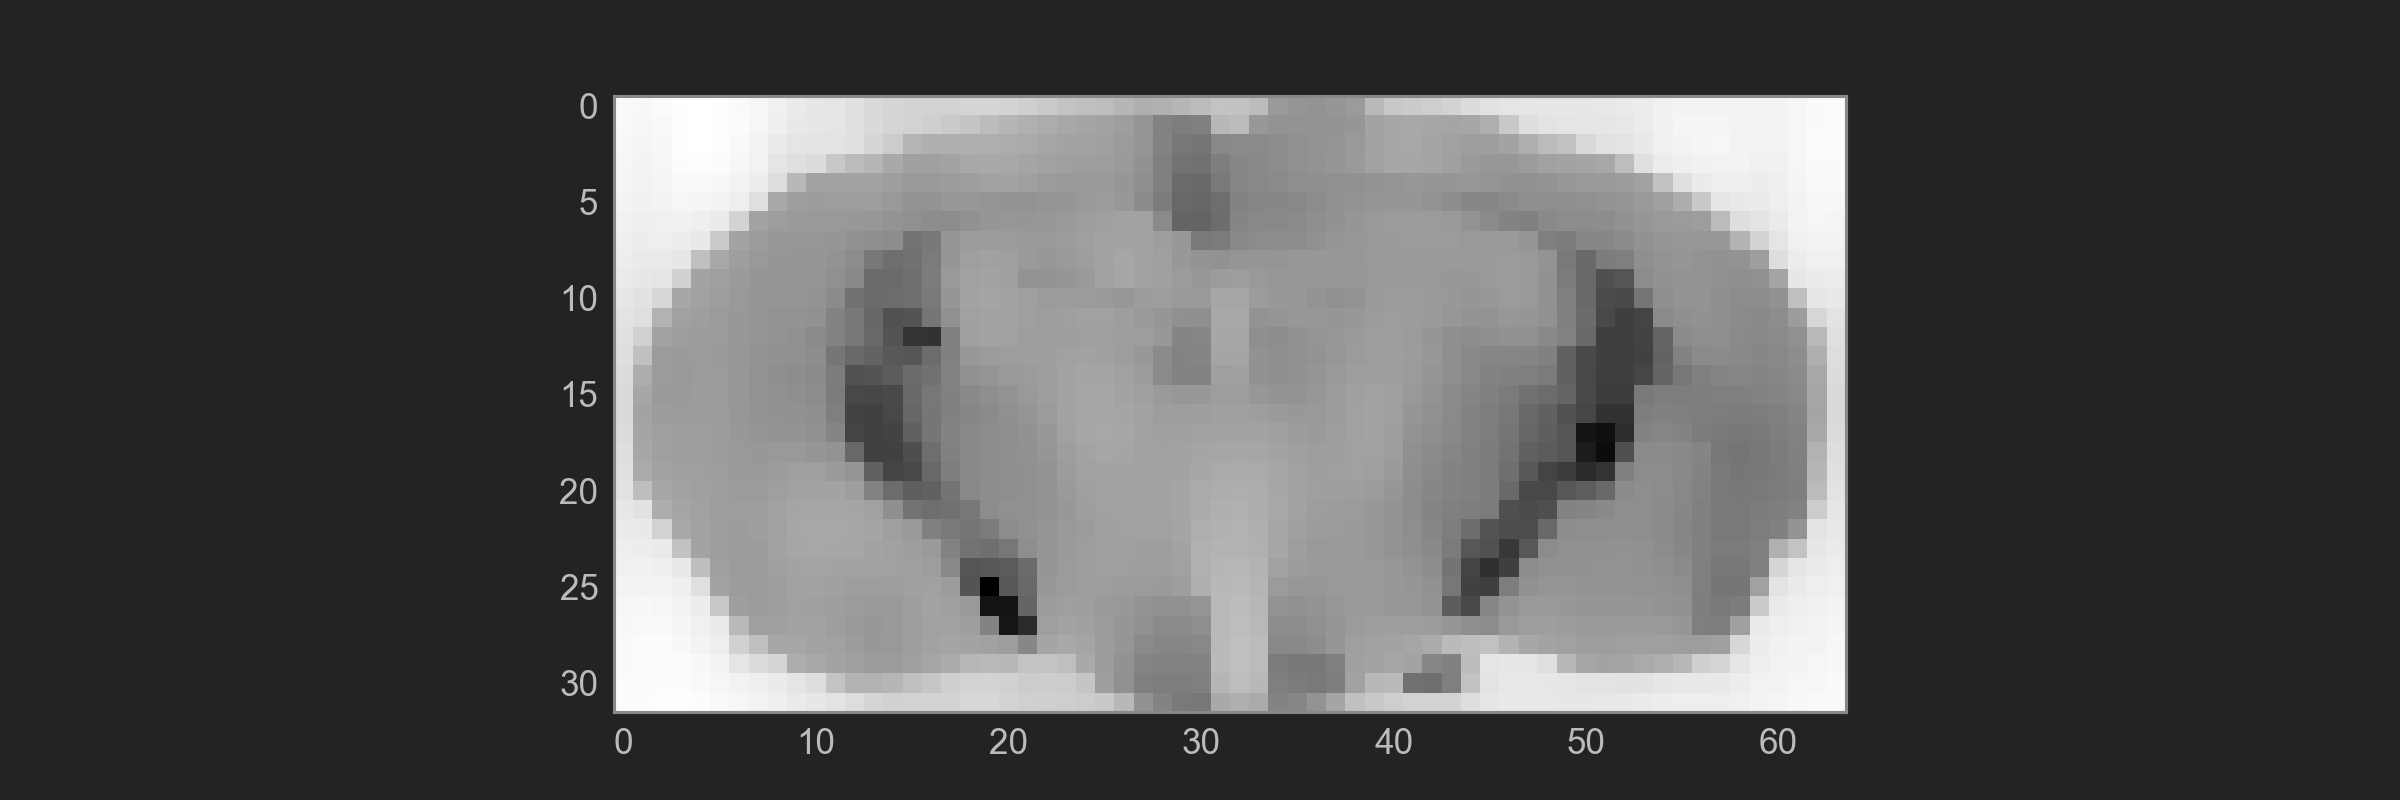

In [30]:
objective = ops.solvers.objectivefunctions.L2(A, y) + 5e-3 * ops.solvers.regularizers.TV(image_size)

solver = ops.solvers.Fista(objective)

x_opt = solver.solve(iteration_count=200, step_size=0.1)

plt.figure()
plt.imshow(yp.abs(x_opt))

In [ ]:
TV_af = ops.solvers.regularizers.TV(image_size, backend='arrayfire')
TV_np = ops.solvers.regularizers.TV(image_size, backend='numpy')

x_af = yp.rand(image_size, backend='arrayfire') - 0.4
x_np = np.asarray(x_af)

print(TV_af * x_af)
print(TV_np * x_np)

alpha = 1e-10
plt.figure()
plt.subplot(131)
plt.imshow(yp.real(TV_np.prox(x_np, alpha)))
plt.subplot(132)
plt.imshow(yp.real(TV_af.prox(x_af, alpha)))
plt.subplot(133)
plt.imshow(yp.real(np.asarray(TV_af.prox(x_af, alpha)) - TV_np.prox(x_np, alpha)))
plt.colorbar()

## Objective Functions and Inversion

In [ ]:
# Generate Objective
objective = objectivefunctions.L2(A, y)

# Generate Object
x0 = yp.ones(objective.N, global_dtype, global_backend)

# Show latex
objective.latex()

plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(yp.abs(object_true))
plt.subplot(132)
plt.imshow(yp.abs(objective.gradient(yp.zeros_like(object_true))))
plt.subplot(133)
plt.imshow(yp.abs(objective.invert()))

## Positivity Regularization

In [ ]:
objective_positivity = objective + 1e-3 * regularizers.Positivity(image_size)

x_opt = solvers.Fista(objective_positivity).solve(iteration_count=50, display_type='text', step_size=0.1, display_iteration_delta=50, 
                                                   use_nesterov_acceleration=True, nesterov_restart_enabled=True)
# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.colorbar()

## Inversion and Registration

### Without Extra operator

In [ ]:
# Define true shift
shift = yp.asarray((2,5))

# Create Registration Operator
R = ops.Registration(object_true)

# Generate shifted copies
y = R * shift

# Generate objective function
objective = objectivefunctions.L2(R, y)
objective.latex()

# Calculate inverse
assert np.all(np.asarray(objective.invert()) == np.asarray(shift))

# Perform gradient descent
x_opt = solvers.GradientDescent(objective).solve(iteration_count=200, display_type='text', step_size=5e-6, display_iteration_delta=50, 
                                                   use_nesterov_acceleration=True, nesterov_restart_enabled=True)


assert yp.sum(yp.abs(yp.real(x_opt) - shift)) < 1e-6

## With Extra Operator

In [ ]:
# Define true shift
shift_true = yp.asarray((10,5))

# Create Registration Operator
R = ops.Registration(object_true)

# Create invertable convolution operator
C = ops.Convolution(h)

# Generate shifted copies
A = C * R
y = A * shift_true

# Generate objective function
objective = objectivefunctions.L2(A, y)

# Calculate inverse
assert np.all(np.asarray(objective.invert()) == np.asarray(shift_true))

# Perform gradient descent
x_opt = solvers.GradientDescent(objective).solve(iteration_count=200, display_type='text', step_size=5e-6, display_iteration_delta=50, 
                                                 use_nesterov_acceleration=True, nesterov_restart_enabled=True)


assert yp.sum(yp.abs(yp.real(x_opt) - shift_true)) < 1e-6

## Generate Measurements

In [ ]:
# Options
shift_offsets_true = ((0,0) ,(0,10), (0,0))
crop_size = (image_size[0], image_size[0])

# Initializations
x = object_true
s = ((0,0) ,(0,0), (0,0))

# Crop operations
X_list = [ops.Crop(image_size, crop_size, crop_start=(0,0)),
          ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)),
          ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2))]

# Set correct shift offsets
for crop_op, offset in zip(X_list, shift_offsets_true):
    args = crop_op.arguments
    args['crop_offset'] = offset
    crop_op.arguments = args
    
# Stack operators
X = ops.Vstack(X_list)

# Convolution operators
h_crop = ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4)) * h  #yp.rand(h.shape)
                  
C_list = [ops.Convolution(h_crop, inverse_regularizer=0, label='C_1'),
          ops.Convolution(h_crop, inverse_regularizer=0, label='C_2'),
          ops.Convolution(h_crop, inverse_regularizer=0, label='C_3')]
C = ops.Dstack(C_list)

# Registration Operators
R_list = [ops.Registration(x, inside_operator=X) for X in X_list]
R = ops.Dstack(R_list)

# Create Composite Operators
A_shift = C * R
A_object = C * X

# Generate measurements
y = A_object * object_true

# Generate objective functions
O_shift = objectivefunctions.L2(A_shift, y)
O_object = objectivefunctions.L2(A_object, y)

O_shift.latex()
O_object.latex()

# Show results
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(yp.abs(x), cmap='gray')
plt.colorbar()
plt.subplot(132)
plt.imshow(yp.abs(y), cmap='gray')
plt.colorbar()
plt.subplot(133)
plt.imshow(yp.abs(O_object.invert()), cmap='gray')
# plt.colorbar()

## Operator-Based Solution

In [ ]:
# Generate Crop Operators
CR_list = [ops.Crop(image_size, crop_size, crop_start=(0,0), label='CR1'),
           ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 4), label='CR2'),
           ops.Crop(image_size, crop_size, crop_start=(0,image_size[1] // 2), label='CR3')]
CR = ops.Vstack(CR_list)

# Generate new forward model to perform registration
Q = ops.MultiMeasurementRegistration(CR_list, debug=True, object_iterate=None)

# Generate Forward model for shift (parallel)
A_shift = C * Q

# Generate forward model for object
A_object = C * CR
x_uncorrected = A_object.inv * y

# Show forward model
Q.latex()

# Invert shift
shift_recovered = A_shift.inv * y


print(np.abs(np.asarray(shift_recovered)))
print(shift_offsets_true)

plt.figure(figsize=(13,3))
plt.subplot(121)
plt.imshow(yp.abs(x_uncorrected), cmap='gray')
plt.title('Deconvolved Object (Uncorrected)')

# Set arguments
_shift_recovered = yp.reshape(shift_recovered, (3,2))
args = CR.arguments
for arg, shift in zip(args, _shift_recovered):
    arg['crop_offset'] =  np.asarray(shift)[0]
CR.arguments = args

plt.subplot(122)
plt.imshow(yp.abs(A_object.inv * y), cmap='gray')
plt.title('Deconvolved Object (Corrected)')